`Import modules`

In [29]:
import os

# Cache
from joblib import Memory

# Data
import numpy as np
import pandas as pd

# Stats
import scipy.stats as stats
from scipy.stats import spearmanr
from scipy.stats import linregress
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import pingouin as pg

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import r2_score

# CDSS
from ai_cdss.data_loader import DataLoader
from ai_cdss.data_processor import DataProcessor
from ai_cdss.constants import *

from cdss_utils import expand_session, check_session, safe_merge, filter_study_range, get_confidence_intervals, generate_patient_protocol_report

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec


## Data Setup

`Clinical data`

In [38]:
# clinical_scores = pd.read_csv("data/nest_T01.csv")
    # clinical_scores['DIFF'] = clinical_scores['T1'] - clinical_scores['T0']
clinical_scores = pd.read_csv("data/nest_clinical.csv")
nest_patient = [204, 775, 787, 788, 946, 947, 953, 955, 957, 1123, 1169, 1170, 1171, 1172, 1173, 1222, 1551, 1553, 1555, 1556, 2110, 2913, 2925, 2926, 2937, 2955, 2956, 2957, 2958, 2959, 2960, 2961, 2962, 2963, 3210, 3213]

In [37]:
clinical_scores

,PATIENT_ID,FM_TOTAL,T0,T1
0,953,0,38,38
1,955,0,44,44
2,946,1,45,46
3,947,0,65,65
4,957,0,32,32
5,1555,0,59,59
6,1551,0,25,25
7,1553,0,34,34
8,1556,0,51,51
9,1222,0,64,64


`RGS data`

In [31]:
memory = Memory(location='cache_dir', verbose=0)

@memory.cache
def load_session_cached(patient_list):
    return check_session(loader.load_session_data(patient_list=patient_list))

@memory.cache
def load_timeseries_cached(patient_list):
    return loader.load_timeseries_data(patient_list=patient_list)

SAVE_DATA = True
EXPAND = False

# NEST DATA
# nest_patient = [
#     775,  787,  788, 1123, 1169, 1170, 1171, 1172, 1173, 1983, 2110, 2195,
#     2955, 2956, 2957, 2958, 2959, 2960, 2961, 2962, 2963, 3081, 3229, 3318, 3432
# ]

rgs_mode = "app"
scoring_weights = [1, 1, 1]
ewma_alpha = 0.2

n = 12
days = 7
protocols_per_day = 5

loader = DataLoader(rgs_mode=rgs_mode)
processor = DataProcessor(weights=scoring_weights, alpha=ewma_alpha)

# Compute ppf

# Load Data
session = load_session_cached(nest_patient)
timeseries = load_timeseries_cached(nest_patient)
ppf = loader.load_ppf_data(patient_list=nest_patient)


protocol_similarity = loader.load_protocol_similarity()
protocol_metrics = loader.load_protocol_init()

# Process Data
session = session.dropna(subset=["ADHERENCE"])
ts = processor.aggregate_dms_by_time(timeseries)
ts = ts.sort_values(by=BY_PPST)

# Merge
data = safe_merge(session, ts, on=BY_PPS, how="inner", left_name="session", right_name="ts")
nest_data = safe_merge(data, ppf, on=BY_PP, how="left", left_name="session", right_name="ppf")
nest_data.sort_values(by=BY_PPST, inplace=True)

# Expand with non-performed sessions
nest_data_all = expand_session(nest_data)
study_data = nest_data_all.groupby('PATIENT_ID', group_keys=False).apply(filter_study_range)
study_data['DAY_INDEX'] = study_data.groupby('PATIENT_ID')['SESSION_DATE'].transform(
    lambda x: (x - x.min()).dt.days
)

study_data.to_parquet("data/nest_data_6weeks.parquet", index=False)
nest_data_all.to_parquet("data/nest_data.parquet", index=False)

INFO:ai_cdss.data_loader:PPF data loaded successfully.
INFO:ai_cdss.data_loader:Protocol similarity data loaded successfully.
INFO:ai_cdss.data_loader:Protocol initialization data loaded successfully.
/tmp/ipykernel_1021823/1837750120.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  study_data = nest_data_all.groupby('PATIENT_ID', group_keys=False).apply(filter_study_range)


In [32]:
from pathlib import Path
# Define PPF file path
output_dir = Path.home() / ".ai_cdss" / "output"

# Check if file exists
if (output_dir / "ppf.parquet").exists():
    ppf_data = pd.read_parquet(path = output_dir / "ppf.parquet").reset_index()

## EDA

`Patient-level metrics`

In [39]:
results = []

for idx, (patient, group) in enumerate(study_data.groupby('PATIENT_ID')):
    # print(f"Patient: {patient}")

    # Calculate features
    total_sessions = group["SESSION_ID"].nunique()
    time_spent = group.drop_duplicates(subset=["SESSION_ID"])["SESSION_DURATION"].sum()
    total_days = (group["SESSION_DATE"].max() - group["SESSION_DATE"].min()).days
    total_ppf = group.drop_duplicates(subset=["SESSION_ID"])["PPF"].sum() / total_sessions
    unique_protocols = group["PROTOCOL_ID"].nunique()

    # Prepare storage for protocol-specific slopes
    protocol_slopes = []

    # Group by protocol
    for protocol, proto_data in group.groupby('PROTOCOL_ID'):
        proto_data = proto_data.sort_values(by="SESSION_DATE").reset_index(drop=True)
        session_order = np.arange(len(proto_data))
        dm_values = proto_data["DM_VALUE"].values

        # Compute DM slope per protocol
        if len(session_order) > 1 and np.std(dm_values) > 0:
            slope, intercept, r_value, p_value, std_err = linregress(session_order, dm_values)
            protocol_slopes.append(slope)

    # Aggregate protocol slopes
    if protocol_slopes:
        dm_slope_avg = np.mean(protocol_slopes) 
    else:
        dm_slope_avg = np.nan  # No valid protocols

    # Expand session batch 
    study_data_session = group.copy()
    study_data_session = group.sort_values(by=["DAY_INDEX", "SESSION_ID", "SECONDS_FROM_START"])
    study_data_session.drop_duplicates(subset=BY_PPS, keep="last", inplace=True)

    # Calculate CDSS score diff
    # score_diff = study_data_session["CDSS_SCORE"].iloc[-1] - study_data_session["CDSS_SCORE"].iloc[0]

    # Calculate adherence
    adherence = study_data_session["ADHERENCE"].mean()
    total_rows = study_data_session.shape[0]

    results.append({
        "PATIENT_ID": patient,
        "TOTAL_SESSIONS": total_sessions,
        "TOTAL_DAYS_SPAN": total_days,
        "UNIQUE_PROTOCOLS": unique_protocols,
        "TOTAL_PPF": total_ppf,
        "TIME_SPENT": time_spent,
        "MEAN_ADHERENCE": adherence,
        "DM_SLOPE": dm_slope_avg,  # Aggregated protocol-wise slope
        "TOTAL_ROWS": total_rows,
        # "DELTA_CDSS_SCORE": score_diff
    })

# Convert to DataFrame
summary_df = pd.DataFrame(results)

/tmp/ipykernel_1021823/4028638722.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  total_ppf = group.drop_duplicates(subset=["SESSION_ID"])["PPF"].sum() / total_sessions


In [40]:
df = summary_df.merge(clinical_scores, on="PATIENT_ID", how="left")

#### Correlation

Exploratory analsyis on feature correlations

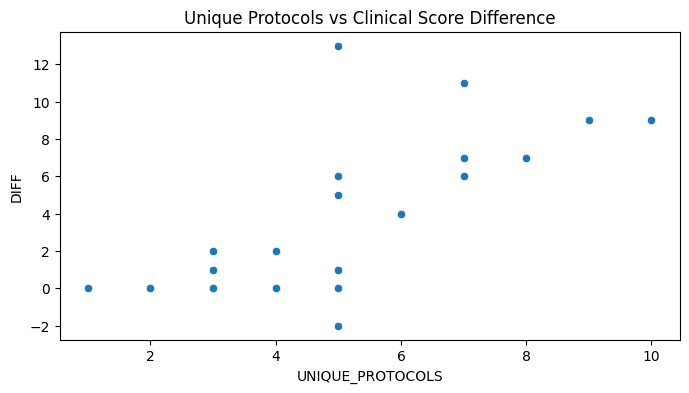

Spearman Correlation between UNIQUE_PROTOCOLS and DIFF
0.775972820455615 2.697970477112392e-08


In [41]:
plt.figure(figsize=(8,4))
sns.scatterplot(df, x="UNIQUE_PROTOCOLS", y="DIFF")
plt.title("Unique Protocols vs Clinical Score Difference")
plt.show()

print("Spearman Correlation between UNIQUE_PROTOCOLS and DIFF")
correlation, p_value = spearmanr(df['UNIQUE_PROTOCOLS'], df['DIFF'])
print(correlation, p_value)

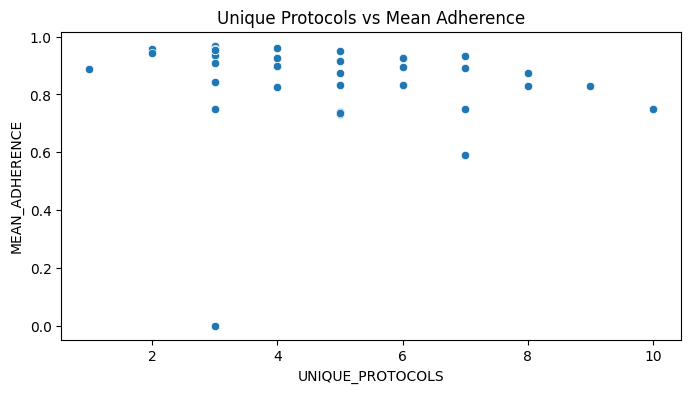

Spearman Correlation between UNIQUE_PROTOCOLS and MEAN_ADHERENCE
-0.4641583057482249 0.004349891292624639


In [42]:
plt.figure(figsize=(8,4))
sns.scatterplot(df, x="UNIQUE_PROTOCOLS", y="MEAN_ADHERENCE")
plt.title("Unique Protocols vs Mean Adherence")
plt.show()

print("Spearman Correlation between UNIQUE_PROTOCOLS and MEAN_ADHERENCE")
correlation, p_value = spearmanr(df['MEAN_ADHERENCE'], df['UNIQUE_PROTOCOLS'])
print(correlation, p_value)

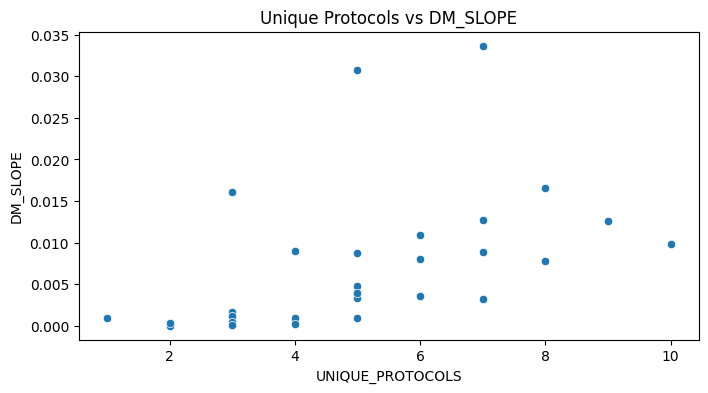

Spearman Correlation between UNIQUE_PROTOCOLS and DM_SLOPE
nan nan


In [43]:
plt.figure(figsize=(8,4))
sns.scatterplot(df, x="UNIQUE_PROTOCOLS", y="DM_SLOPE")
plt.title("Unique Protocols vs DM_SLOPE")
plt.show()

print("Spearman Correlation between UNIQUE_PROTOCOLS and DM_SLOPE")
correlation, p_value = spearmanr(df['DM_SLOPE'], df['UNIQUE_PROTOCOLS'])
print(correlation, p_value)

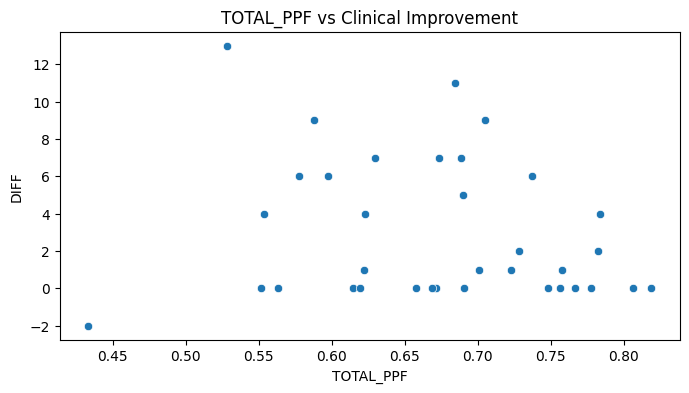

Spearman Correlation between UNIQUE_PROTOCOLS and TOTAL_PPF
-0.17009495580219117 0.3212932528595446


In [44]:
plt.figure(figsize=(8,4))
sns.scatterplot(df, x="TOTAL_PPF", y="DIFF")
plt.title("TOTAL_PPF vs Clinical Improvement")
plt.show()

print("Spearman Correlation between UNIQUE_PROTOCOLS and TOTAL_PPF")
correlation, p_value = spearmanr(df['TOTAL_PPF'], df['DIFF'])
print(correlation, p_value)

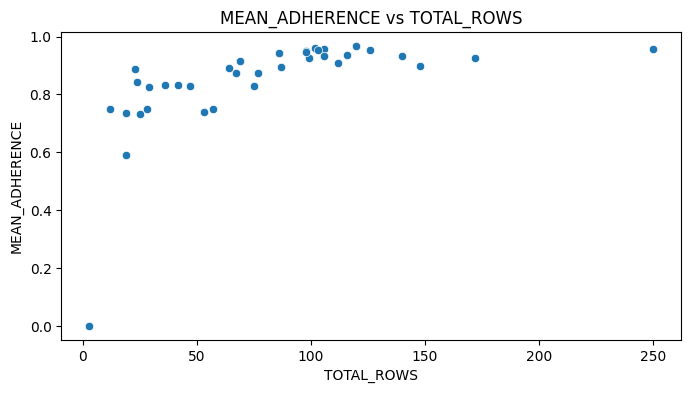

Spearman Correlation between MEAN_ADHERENCE and TOTAL_SESSIONS
0.8329042293526313 2.9581550516343243e-10


In [45]:
plt.figure(figsize=(8,4))
sns.scatterplot(df, x="TOTAL_ROWS", y="MEAN_ADHERENCE")
plt.title("MEAN_ADHERENCE vs TOTAL_ROWS")
plt.show()

print("Spearman Correlation between MEAN_ADHERENCE and TOTAL_SESSIONS")
correlation, p_value = spearmanr(df['TOTAL_ROWS'], df['MEAN_ADHERENCE'])
print(correlation, p_value)

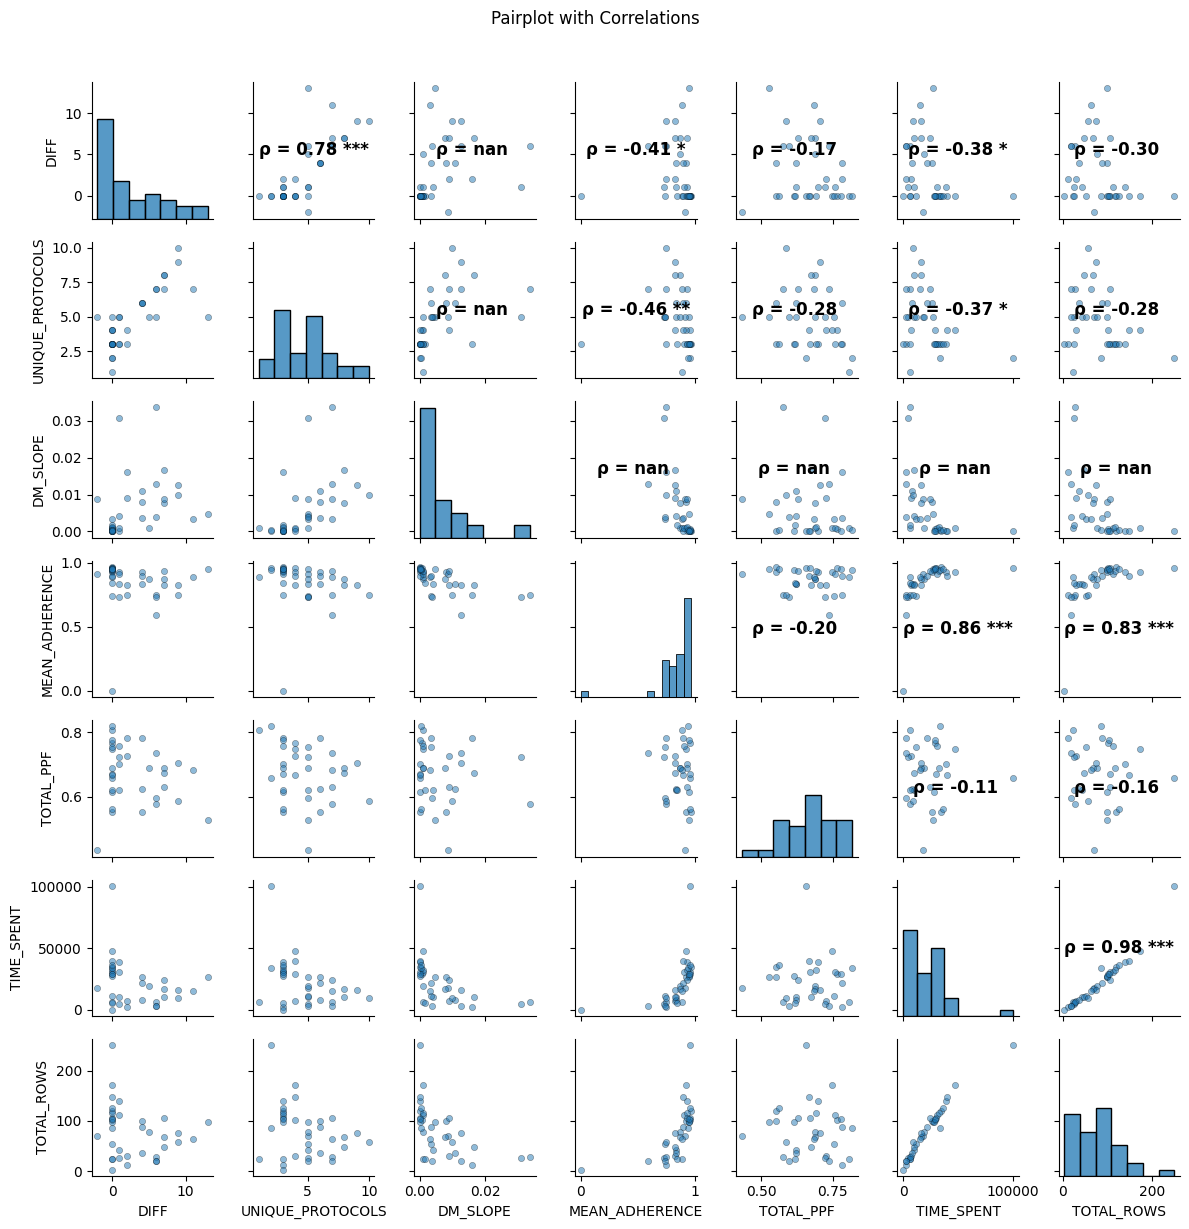

In [46]:
vars_to_plot = ["DIFF", "UNIQUE_PROTOCOLS", "DM_SLOPE", "MEAN_ADHERENCE", "TOTAL_PPF", "TIME_SPENT", "TOTAL_ROWS"]
n_vars = len(vars_to_plot)
desired_total_height = 12
height = desired_total_height / n_vars

def corrfunc(x, y, **kws):
    r, p = spearmanr(x, y)
    ax = plt.gca()

    # Significance stars
    if p < 0.001:
        stars = '***'
    elif p < 0.01:
        stars = '**'
    elif p < 0.05:
        stars = '*'
    else:
        stars = ''

    ax.annotate(f'ρ = {r:.2f} {stars}',
                xy=(0.5, 0.5), xycoords=ax.transAxes,
                ha='center', va='center',
                fontsize=12, fontweight='bold')

# Plot
g = sns.pairplot(
    df[vars_to_plot],
    corner=False,
    plot_kws={'alpha': 0.5, 's': 20, 'edgecolor': 'k'},
    height=height,
    aspect=1  # keep square plots
)

# Map correlation function to upper triangle
g.map_upper(corrfunc)

plt.suptitle("Pairplot with Correlations", y=1.02)
plt.tight_layout()
plt.show()


#### Testing

---

Does the number of unique protocols assigned to each patient predict clinical improvement (pre-post difference in score), controlling for the total number of sessions and baseline severity (T0)?


In [47]:
model_clinical = smf.ols('DIFF ~ UNIQUE_PROTOCOLS + TOTAL_SESSIONS + T0', data=df)
result = model_clinical.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   DIFF   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     16.21
Date:                Wed, 16 Apr 2025   Prob (F-statistic):           1.39e-06
Time:                        09:37:33   Log-Likelihood:                -81.648
No. Observations:                  36   AIC:                             171.3
Df Residuals:                      32   BIC:                             177.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -1.5273      2.200  

- Number of unique protocols significantly predicts clinical improvement (p = 0.001). 

- For each additional unique protocol played, the model predicts a +1.28 point increase in clinical score improvement. 

- Model predicts 44% of the variance in clinical improvement.


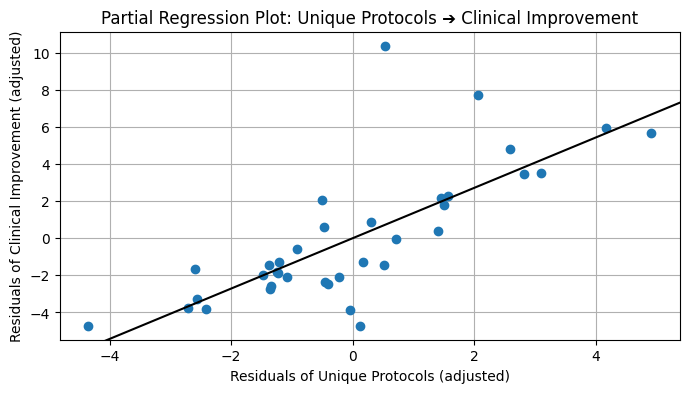

In [48]:
# Prepare your variables
X = df[['UNIQUE_PROTOCOLS', 'TOTAL_SESSIONS', 'T0']]
y = df['DIFF']

# Fit the full model
model = sm.OLS(y, sm.add_constant(X)).fit()

# Create the partial regression plot for UNIQUE_PROTOCOLS
fig = plt.figure(figsize=(8, 4))
sm.graphics.plot_partregress(
    endog='DIFF',
    exog_i='UNIQUE_PROTOCOLS',
    exog_others=['TOTAL_SESSIONS', 'T0'],
    data=df,
    obs_labels=False,
    ax=fig.add_subplot(111)
)

plt.title('Partial Regression Plot: Unique Protocols ➔ Clinical Improvement')
plt.xlabel('Residuals of Unique Protocols (adjusted)')
plt.ylabel('Residuals of Clinical Improvement (adjusted)')
plt.grid(True)
plt.show()

In [49]:
model_adh = smf.ols('MEAN_ADHERENCE ~ UNIQUE_PROTOCOLS + TOTAL_SESSIONS + T0', data=df)
result = model_adh.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:         MEAN_ADHERENCE   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     6.230
Date:                Wed, 16 Apr 2025   Prob (F-statistic):            0.00187
Time:                        09:37:49   Log-Likelihood:                 21.550
No. Observations:                  36   AIC:                            -35.10
Df Residuals:                      32   BIC:                            -28.77
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.8204      0.125  

## CDSS - Score Report

For each patient protocol score let's study the dynamics of the metrics we are using to provide data-driven recommendations.

Particularly focusing on DM modelling / smoothing and reliability of this metric to measure protocol learning, and adherence analysis to assess if it might be driven by protocol preference. Also a note on the objective function we are optimizing.

### DM

In [50]:
nest_dms = study_data.copy()
nest_dms = nest_dms[BY_ID + ["SECONDS_FROM_START", "DM_VALUE", "PE_VALUE", "ADHERENCE", "PPF", "CONTRIB", "DAY_INDEX"]]
nest_dms.sort_values(
    by=["PATIENT_ID", "DAY_INDEX", "SESSION_ID", "SECONDS_FROM_START"],
    inplace=True,
)


Different methods to smooth / model the DM timeseries:
- Smoothing: EWMA, Savgol Filter
- Modelling: Logistic Curve

In [51]:
def compute_metrics(
        df,
        alpha=0.5,
        window_size=7,
        scaling_factor=2,
        min_window=5,
        max_window=21,
        polyorder=2,
        deriv=1,
    ):
    from scipy import signal
    df = df.reset_index(drop=True)

    # Parameter for Savitzky-Golay
    window_length = window_size or int(np.clip(1 / alpha * scaling_factor, min_window, max_window))
    if window_length % 2 == 0:
        window_length += 1

    # Time index
    t = np.arange(len(df))
    t_safe = t + 1  # to avoid log(0)

    df['DM_VALUE_EWMA'] = df['DM_VALUE'].ewm(alpha=alpha, adjust=True).mean()
    
    # Delta DM
    dm_roll = df['DM_VALUE'].rolling(window=10, step=10).mean()
    df['DELTA_DM_ROLL'] = signal.resample(pd.Series(dm_roll).diff().fillna(0), df['DM_VALUE'].size)
    df['DELTA_DM'] = df['DM_VALUE_EWMA'].diff().fillna(0)
    
    # EWMA
    df['DELTA_DM_EWMA'] = df['DELTA_DM'].ewm(alpha=alpha, adjust=True).mean()
    

    # Savitzky-Golay filter
    try:
        df['SG_DM_D0'] = savgol_filter(df['DM_VALUE'], window_length=window_length, polyorder=polyorder, deriv=0)
        df['SG_DM'] = savgol_filter(df['DM_VALUE'], window_length=window_length, polyorder=polyorder, deriv=deriv)
    except ValueError:
        df['SG_DM'] = df['DM_VALUE']

    try:
        valid = df.dropna(subset=['DELTA_DM_EWMA', 'PE_VALUE'])

        if len(valid) > 2:
            # Compute standard deviations
            dm_std = np.std(valid['DM_VALUE'])
            perf_std = np.std(valid['PE_VALUE'])

            # Avoid division by zero
            if perf_std > 0 and dm_std > 0:
                # Metric 1: DM fluctuation relative to performance
                dm_perf_ratio = dm_std / perf_std

                # Metric 2: Performance fluctuation relative to DM
                perf_dm_ratio = perf_std / dm_std

                # Normalized difference
                norm_diff = (dm_std - perf_std) / perf_std
            else:
                dm_perf_ratio = np.nan
                perf_dm_ratio = np.nan
                norm_diff = np.nan
        else:
            dm_perf_ratio = np.nan
            perf_dm_ratio = np.nan
            norm_diff = np.nan
    except Exception as e:
        print(f"[DM Variability Metrics] Failed: {e}")
        dm_perf_ratio = perf_dm_ratio = norm_diff = np.nan

    # Store in attributes
    df.attrs.update({
        'dm_perf_ratio': dm_perf_ratio,
        'perf_dm_ratio': perf_dm_ratio,
        'dm_perf_norm_diff': norm_diff
    })
    # # === Logarithmic Fit ===
    # def log_func(x, a, b):
    #     return a * np.log(x + 1) + b

    # try:
    #     popt_log, pcov_log = curve_fit(log_func, t_safe, df['DM_VALUE'], maxfev=10000)
    #     df['LOG_FIT_DM'] = log_func(t_safe, *popt_log)
    #     r2_log = r2_score(df['DM_VALUE'], df['LOG_FIT_DM'])
    #     ci_log = get_confidence_intervals(popt_log, pcov_log)
    # except Exception as e:
    #     df['LOG_FIT_DM'] = np.nan
    #     popt_log = (np.nan, np.nan)
    #     r2_log = np.nan
    #     ci_log = [(np.nan, np.nan)] * 2
    #     print(f"[Log Fit] Failed: {e}")

    # # === Exponential Fit ===
    # def exp_func(x, a, b, c):
    #     return a * np.exp(-b * x) + c

    # try:
    #     popt_exp, pcov_exp = curve_fit(exp_func, t, df['DM_VALUE'], maxfev=10000)
    #     df['EXP_FIT_DM'] = exp_func(t, *popt_exp)
    #     r2_exp = r2_score(df['DM_VALUE'], df['EXP_FIT_DM'])
    #     ci_exp = get_confidence_intervals(popt_exp, pcov_exp)
    # except Exception as e:
    #     df['EXP_FIT_DM'] = np.nan
    #     popt_exp = (np.nan, np.nan, np.nan)
    #     r2_exp = np.nan
    #     ci_exp = [(np.nan, np.nan)] * 3
    #     print(f"[Exp Fit] Failed: {e}")

    # === Logistic Fit ===
    # def logistic_func(x, L, k, x0):
    #     return L / (1 + np.exp(-k * (x - x0)))

    # try:
    #     popt_logistic, pcov_logistic = curve_fit(
    #         logistic_func, t, df['DM_VALUE'],
    #         p0=[1.0, 1.0, np.median(t)],
    #         maxfev=10000
    #     )
    #     df['LOGISTIC_FIT_DM'] = logistic_func(t, *popt_logistic)
    #     r2_logistic = r2_score(df['DM_VALUE'], df['LOGISTIC_FIT_DM'])
    #     ci_logistic = get_confidence_intervals(popt_logistic, pcov_logistic)
    # except Exception as e:
    #     df['LOGISTIC_FIT_DM'] = np.nan
    #     popt_logistic = (np.nan, np.nan, np.nan)
    #     r2_logistic = np.nan
    #     ci_logistic = [(np.nan, np.nan)] * 3
    #     print(f"[Logistic Fit] Failed: {e}")

    # # Store everything in attrs
    # df.attrs.update({
    #     # Logarithmic
    #     # 'log_fit_params': popt_log,
    #     # 'log_fit_r2': r2_log,
    #     # 'log_fit_ci': ci_log,

    #     # Exponential
    #     # 'exp_fit_params': popt_exp,
    #     # 'exp_fit_r2': r2_exp,
    #     # 'exp_fit_ci': ci_exp,

    #     # Logistic
    #     'logistic_fit_params': popt_logistic,
    #     'logistic_fit_r2': r2_logistic,
    #     'logistic_fit_ci': ci_logistic,
    # })

    df['DELTA_DM_ROLL_SCALED'] = (df['DELTA_DM_ROLL'] - df['DELTA_DM_ROLL'].min()) / (df['DELTA_DM_ROLL'].max() - df['DELTA_DM_ROLL'].min() + 1e-8)
    # df['ADHERENCE_SCALED'] = (df['ADHERENCE'] - df['ADHERENCE'].min()) / (df['ADHERENCE'].max() - df['ADHERENCE'].min() + 1e-8)

    # Compute score
    a = 1
    b = 1
    c = 1
    df['CDSS_SCORE'] = a * df['PPF'] + b * df['DELTA_DM_ROLL_SCALED'] + c * df['ADHERENCE']

    return df

In [52]:
def plot_fit(df, filename=None):
    # Plotting
    fig = plt.figure(figsize=(12, 8))
    spec = gridspec.GridSpec(3, 1, height_ratios=[3, 1, 1])  # 3/4 for DM, 1/4 for PE

    # --- DM
    ax_dm = fig.add_subplot(spec[0])
    sns.lineplot(data=df, x=df.index, y='DM_VALUE', color='black', alpha=.1)
    sns.lineplot(data=df, x=df.index, y='LOGISTIC_FIT_DM', color='orange', alpha=0.8, label="Logistic Curve")
    # df["SG_DM_CUM"] = df['SG_DM'].cumsum()
    # sns.lineplot(data=df, x=df.index, y='SG_DM_D0', color='purple', alpha=0.8, label="Savgol")
    sns.lineplot(data=df, x=df.index, y='DM_VALUE_EWMA', alpha=0.8, label="EWMA")


    ax_dm.set_xlabel('')
    ax_dm.set_ylabel('DM Value')
    ax_dm.tick_params(labelbottom=False)
    ax_dm.spines['right'].set_visible(False)

    # --- PE
    ax_pe = fig.add_subplot(spec[1], sharex=ax_dm)
    sns.lineplot(data=df, x=df.index, y='PE_VALUE', color='green', alpha=0.5)
    plt.axhline(y=0.7, color='r', linestyle='--')
    ax_pe.set_ylabel('PE Value')
    ax_pe.set_xlabel('Timepoint')

    if filename:
        plt.savefig(filename, bbox_inches='tight')
    else:
        plt.show()
    plt.close()

Patient: 775, Session: 206
0.085


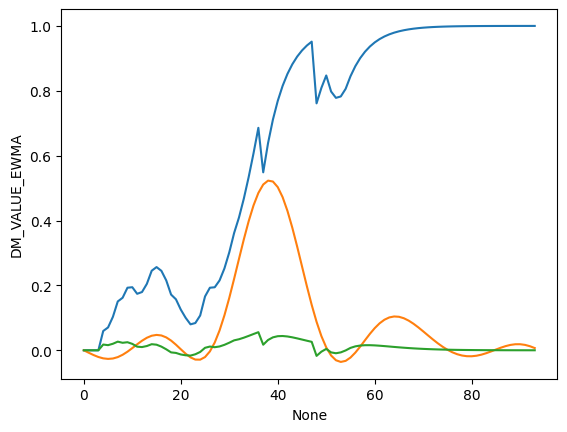

In [53]:
for i, g in nest_dms.groupby(BY_PP):
    if i[0] != 775:
        continue

    df = compute_metrics(g, alpha=0.20)
    # plot_fit(df)

    print(f"Patient: {i[0]}, Session: {i[1]}")

    sns.lineplot(df, y="DM_VALUE_EWMA", x=df.index)
    sns.lineplot(df, y="DELTA_DM_ROLL", x=df.index)
    sns.lineplot(df, y="DELTA_DM_EWMA", x=df.index)

    print(np.mean(df['DELTA_DM_ROLL']))
    # print(f"Logistic Fit Params: {df.attrs['logistic_fit_params']}, R²: {df.attrs['logistic_fit_r2']}")

    # signal = df['LOGISTIC_FIT_DM']
    # noise = df['DM_VALUE'] - df['LOGISTIC_FIT_DM']

    # snr_model = np.var(signal) / np.var(noise)
    # print(f"SNR (Logistic Model): {snr_model}")
    # r2 = df.attrs['logistic_fit_r2']
    # print(f"SNR (from R2): {r2 / (1 - r2)}]")

    break
    # plt.show()

    # plt.figure(figsize=(8, 2))
    # sns.lineplot(df, x=df.index, y="PE_VALUE")
    # plt.axhline(y=0.7, color='r', linestyle='--')
    

ValueError: Could not interpret value `LOGISTIC_FIT_DM` for `y`. An entry with this name does not appear in `data`.

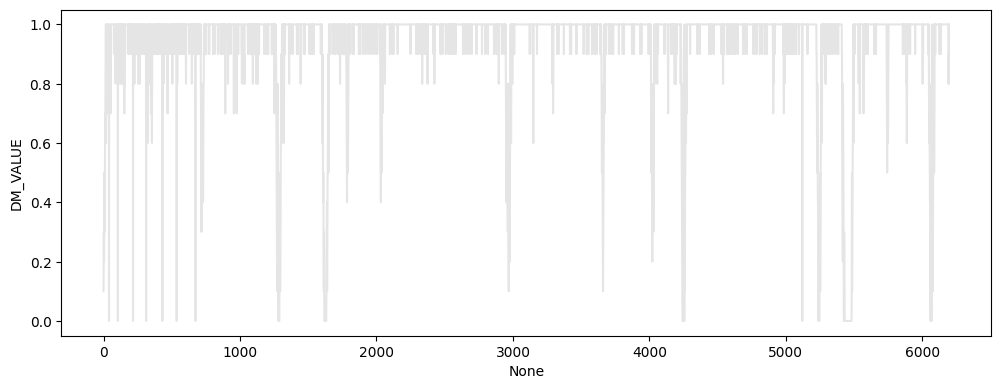

In [54]:
# Prepare output dirs
output_dir = 'figures/nest_dm_metric'
os.makedirs(output_dir, exist_ok=True)

# Results table
results = []

# Iterate over patient-protocols
for (patient_id, protocol_id), group in nest_dms.groupby(BY_PP):
    df = compute_metrics(group)

    plot_filename = f"dm_model_{patient_id}_{protocol_id}.png"
    # Save the plot
    plot_fit(df, filename=os.path.join(output_dir, plot_filename))

    # Extract attributes
    logistic_params = df.attrs['logistic_fit_params']
    logistic_ci = df.attrs['logistic_fit_ci']
    logistic_r2 = df.attrs['logistic_fit_r2']

    # CI widths
    ci_widths = [high - low for (low, high) in logistic_ci]

    # Append to results
    results.append({
        'PATIENT_ID': patient_id,
        'PROTOCOL_ID': protocol_id,
        'logistic_R2': logistic_r2,
        'L': logistic_params[0],
        'k': logistic_params[1],
        'x0': logistic_params[2],
        'CI_L_width': ci_widths[0],
        'CI_k_width': ci_widths[1],
        'CI_x0_width': ci_widths[2],
        'plot_filename': plot_filename,
        'dm_realiability': df.attrs['dm_perf_ratio']
    })

results_df = pd.DataFrame(results)
results_df.to_csv("data/logistic_fit_summary.csv", index=False)

In [ ]:
import base64
import os

html = ['<html><head><title>DM Model Report</title></head><body>']
html.append('<h1>Report: Protocols x Patients</h1>')
html.append('<table border="1" style="border-collapse: collapse;">')

patients = sorted(study_data[PATIENT_ID].unique())
protocols = sorted(study_data[PROTOCOL_ID].unique())

# Table header
html.append('<tr><th>Protocol \\ Patient</th>')
for patient in patients:
    html.append(f'<th>{patient}</th>')
html.append('</tr>')

# Table rows
for protocol in protocols:
    html.append(f'<tr><td><strong>{protocol}</strong></td>')
    for patient in patients:
        dir = 'figures/nest_dm_metric'
        filename = f'dm_model_{patient}_{protocol}.png'
        filepath = os.path.join(dir, filename)
        
        if os.path.exists(filepath):
            with open(filepath, "rb") as image_file:
                encoded = base64.b64encode(image_file.read()).decode('utf-8')
                img_tag = f'<img src="data:image/png;base64,{encoded}" width="200">'
                html.append(f'<td>{img_tag}</td>')
        else:
            html.append('<td> - </td>')  # Empty cell if no image
    html.append('</tr>')

html.append('</table></body></html>')

# Save HTML
output_path = 'reports/nest_dm_model.html'
with open(output_path, 'w') as f:
    f.write('\n'.join(html))

print(f"✅ Report generated at: {output_path}")


In [ ]:
# Plot histogram of R²
plt.figure(figsize=(12, 4))
sns.histplot(results_df['logistic_R2'], bins=20, kde=True)
plt.title('Distribution of Logistic Fit R²')
plt.xlabel('R²')
plt.ylabel('Frequency')
plt.tight_layout()
# plt.savefig(os.path.join(hist_dir, "logistic_r2_distribution.png"))
plt.show()

In [ ]:
count_rows = nest_dms.groupby(BY_PP).size().reset_index(name='COUNT')
results_df = results_df.merge(count_rows, on=BY_PP, how="left")

In [ ]:
plt.figure(figsize=(12, 4))
sns.regplot(results_df, x="COUNT", y="logistic_R2")
plt.show()

plt.figure(figsize=(12, 4))
sns.regplot(results_df, x="dm_realiability", y="logistic_R2")
plt.show()

### Adherence

In [ ]:
def plot_adherence_variability(study_data, filename=None):
    # Step 1: Aggregate mean and SE manually
    adherence_summary = study_data.groupby("DAY_INDEX").agg(
        mean_adherence=('ADHERENCE', 'mean'),
        se_adherence=('ADHERENCE', lambda x: x.std(ddof=1) / (len(x) ** 0.5))
    ).reset_index()

    # Step 2: Plot
    plt.figure(figsize=(13, 5))
    sns.set_theme(style="white")

    # Line without error bar
    sns.lineplot(
        data=study_data,
        x="DAY_INDEX",
        y="ADHERENCE",
        # hue="WEEKEND",
        # marker="o",
        linewidth=2,
        errorbar=None,  # Disable internal error bar
    )

    # Add manual error bars
    plt.errorbar(
        adherence_summary["DAY_INDEX"],
        adherence_summary["mean_adherence"],
        yerr=adherence_summary["se_adherence"],
        fmt='none',
        # ecolor='gray',
        capsize=3,
        capthick=3,
        elinewidth=3
    )

    plt.title(f"Adherence Variability - {study_data.PATIENT_ID.unique()[0]}")
    plt.xlabel("Day Index")
    plt.ylabel("Adherence")
    plt.xticks(range(0, 46, 1))
    plt.xticks(rotation=90)
    plt.ylim(-0.09, 1.09)
    plt.xlim(0, 45)

    # plt.title(f"")

    if filename:
        plt.savefig(filename, dpi=300, bbox_inches="tight")
    else:
        plt.show()

    plt.close()


In [ ]:
nest_session = nest_dms.copy()
nest_session.drop_duplicates(subset=BY_ID, inplace=True)
nest_session[ADHERENCE] = nest_session[ADHERENCE].astype(int)

In [ ]:
j = 0
for i, g in nest_session.groupby(by='PATIENT_ID'):
    plot_adherence_variability(g)#, filename=f"nest_adherence/adherence_variability_{g.name[0]}_{g.name[1]}.png")
    # break
    if j==10:
        break
    j += 1


### Score

In [33]:
def plot_metrics(
        df, 
        show="both",  # Options: "sg", "ewma", "both"
        filename=None,
    ):

    # Plotting
    fig = plt.figure(figsize=(12, 8))
    spec = gridspec.GridSpec(5, 1, height_ratios=[2, 1, 3, 3, 1])  # 3/4 for DM, 1/4 for PE

    # Prepare session markers
    session_start_points = []
    session_end_points = []

    if 'SESSION_ID' in df.columns:
        # Start of sessions
        change_mask = df['SESSION_ID'].ne(df['SESSION_ID'].shift())
        session_start_points = df.index[change_mask].tolist()

        # End of sessions
        session_end_points = df.groupby('SESSION_ID').apply(lambda x: x.index[-1]).values.tolist()

    # Helper: Apply vertical lines to any axis
    def add_session_lines(axis):
        # for cp in session_start_points:
        #     axis.axvline(x=cp, color='red', linewidth=1.2, linestyle='--', alpha=0.7)
        for ep in session_end_points:
            axis.axvline(x=ep, color='green', linewidth=1.2, linestyle=':', alpha=0.7)

    # --- CDSS: Score
    ax_cdss = fig.add_subplot(spec[0])
    sns.lineplot(data=df, x=df.index, y='CDSS_SCORE', color='blue', alpha=0.5)
    ax_cdss.set_xlabel('')
    ax_cdss.set_ylabel('CDSS Score')
    ax_cdss.tick_params(labelbottom=False)
    ax_cdss.spines['right'].set_visible(False)
    add_session_lines(ax_cdss)

    # --- Adherence plot
    ax_ad = fig.add_subplot(spec[1], sharex=ax_cdss)
    sns.lineplot(data=df, x=df.index, y='ADHERENCE', ax=ax_ad, color='blue')
    ax_ad.set_ylim(0, 1.09)
    ax_ad.set_xlabel('')
    ax_ad.set_ylabel('Adherence')
    ax_ad.tick_params(labelbottom=False)
    ax_ad.spines['right'].set_visible(False)
    # ax_ad.spines['bottom'].set_visible(False)
    add_session_lines(ax_ad)
    
    # --- Delta DM
    ax_dm_delta = fig.add_subplot(spec[2], sharex=ax_cdss)
    ax_dm_delta.spines['top'].set_visible(False)
    ax_dm_delta.spines['right'].set_visible(False)
    ax_dm_delta.set_xlabel('')
    ax_dm_delta.set_ylabel('Delta DM')
    # ax_dm_delta.set_ylim(-0.2, 0.2)
    ax_dm_delta.legend(loc='lower right')
    ax_dm_delta.tick_params(labelbottom=False)
    add_session_lines(ax_dm_delta)

    # Secondary axis: Delta DM
    # ax_dm_delta = ax_dm.twinx()
    # Conditional plotting
    if show in ["both", "ewma"]:
        sns.lineplot(data=df, x=df.index, y='DELTA_DM_EWMA', ax=ax_dm_delta, linewidth=1.5, color='orange', label='ΔDM EWMA')
        sns.lineplot(data=df, x=df.index, y='DELTA_DM_ROLL', ax=ax_dm_delta, linewidth=1.5, color='purple', label='ΔDM ROLL')
    if show in ["both", "sg"]:
        sns.lineplot(data=df, x=df.index, y='SG_DM', ax=ax_dm_delta, linewidth=1.5, color='purple', label='ΔDM Savitzky')
    if show == "raw":
        sns.lineplot(data=df, x=df.index, y='DELTA_DM_RAW', ax=ax_dm_delta, linewidth=1.5, color='red', label='ΔDM Raw')

    # --- First plot: DM_VALUE ---
    ax_dm = fig.add_subplot(spec[3], sharex=ax_cdss)
    sns.lineplot(data=df, x=df.index, y='DM_VALUE', ax=ax_dm, alpha=0.8, color='black', linewidth=1)
    sns.lineplot(data=df, x=df.index, y='DM_VALUE_EWMA', ax=ax_dm, linewidth=2)

    ax_dm.set_ylim(0, 1.09)
    # ax_dm.set_title(f'DM value — Patient {i[0]}, Protocol {i[1]}')
    ax_dm.set_xlabel('')
    ax_dm.set_ylabel('DM Value')
    ax_dm.grid(False)
    ax_dm.tick_params(labelbottom=False)
    ax_dm.spines['top'].set_visible(False)
    ax_dm.spines['right'].set_visible(False)
    add_session_lines(ax_dm)

    # --- Second plot: PE_VALUE ---
    ax_pe = fig.add_subplot(spec[4], sharex=ax_dm)
    sns.lineplot(data=df, x=df.index, y='PE_VALUE', ax=ax_pe, color='green')
    ax_pe.axhline(y=0.7, color='darkgreen', linestyle='--', alpha=0.7)

    # ax_pe.set_title('PE Value')
    ax_pe.set_xlabel('Timepoint')
    ax_pe.set_ylabel('PE Value')
    ax_pe.spines['top'].set_visible(False)
    ax_pe.spines['right'].set_visible(False)
    ax_pe.set_ylim(0, 1.09)
    add_session_lines(ax_pe)

    # fig.suptitle(f'Patient {i[0]}, Protocol {i[1]}', fontsize=16)

    plt.tight_layout()

    if filename:
        plt.savefig(filename, dpi=300)
    else:
        plt.show()

    plt.close(fig)

In [ ]:
# Output directory
output_dir = "figures/dms_nest_complete"
os.makedirs(output_dir, exist_ok=True)

custom_params = {"axes.spines.right": True, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

for idx, (i, group) in enumerate(nest_dms.groupby(by=BY_PP)):
    group = group.reset_index(drop=True)  # clean index for plotting

    # Compute metrics
    group = compute_metrics(
        group,
        alpha=0.15,
        window_size=7
    )

    # Save figure
    filename = f"patient_{i[0]}_protocol_{i[1]}.png"
    filepath = os.path.join(output_dir, filename)
    
    # Plot DM
    plot_metrics(
        group,
        show="ewma",
        # filename=filepath
    )
    # break
    break
    print(f"Saved: {filepath}")

# All figures saved
print(f"\nAll figures saved to {output_dir}/")


In [ ]:
def plot_score(group, filename=None):    
    # Heatmap
    pivot = group.pivot_table(
        index='PROTOCOL_ID',
        columns='DAY_INDEX',
        values='CDSS_SCORE',
        aggfunc='last'
    ).astype(float)

    # Ensure all days in x-axis
    all_days = np.arange(group['DAY_INDEX'].min(), group['DAY_INDEX'].max() + 1)
    pivot = pivot.reindex(columns=all_days, fill_value=np.nan)
    pivot = pivot.ffill(axis=1).astype(float)

    # Prepare the figure
    fig = plt.figure(figsize=(12, 4))
    gs = GridSpec(2, 2, width_ratios=[22, 1], height_ratios=[1, 1], figure=fig)

    # Main plot axes
    ax_line = fig.add_subplot(gs[0, 0])
    ax_heatmap = fig.add_subplot(gs[1, 0], sharex=ax_line)

    # Colorbar axes
    cbar_ax = fig.add_subplot(gs[1, 1])

    # --- Line plot ---
    sns.lineplot(
        data=group,
        x='DAY_INDEX',
        y='CDSS_SCORE',
        hue='PROTOCOL_ID',
        marker='o',
        linewidth=2,
        palette='tab10',
        ax=ax_line
    )

    ax_line.set_ylabel("CDSS Score")
    ax_line.set_xlabel("")
    # ax_line.set_title(f"Patient {i} - CDSS Score by Protocol")
    ax_line.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax_line.label_outer()  # remove inner labels

    # --- Heatmap ---
    sns.heatmap(
        pivot,
        annot=False,
        fmt=".2f",
        cmap="YlOrRd",
        cbar_ax=cbar_ax,
        cbar_kws={'label': 'CDSS Score'},
        ax=ax_heatmap
    )

    ax_heatmap.set_xlabel("Day Index")
    ax_heatmap.set_ylabel("Protocol ID")
    ax_heatmap.label_outer()  # remove inner labels

    fig.suptitle(f"Patient {i} - CDSS Score by Protocol")
    plt.tight_layout()

    if filename:
        plt.savefig(filename, dpi=300)
    else:
        plt.show()
    
    plt.close(fig)

In [ ]:
scores = nest_dms.groupby([PATIENT_ID, PROTOCOL_ID]).apply(
    lambda x: 
        compute_metrics(
            x, 
            alpha=0.2, 
            window_size=7
        ),
    include_groups=False
).reset_index()

In [ ]:
output_dir = 'figures/nest_score'
for i, group in scores.groupby(by=PATIENT_ID):    
    plot_score(
        group,
        filename=os.path.join(output_dir, f"patient_{i}_protocols.png")
    )

In [ ]:
# --- Config ---
input_dir = "figures/dms_nest_complete"
heatmap_dir = "figures/nest_score"  # <- your heatmaps directory!
output_html = os.path.join("reports", "nest_gallery.html")

# --- Collect Protocol-Patient Images ---
image_files = [f for f in os.listdir(input_dir) if f.endswith(".png")]

data = []
for filename in image_files:
    try:
        parts = filename.replace(".png", "").split("_")
        patient_id = int(parts[1])
        protocol_id = int(parts[3])
        data.append((protocol_id, patient_id, filename))
    except Exception as e:
        print(f"Skipping file {filename}: {e}")

df = pd.DataFrame(data, columns=["PROTOCOL_ID", "PATIENT_ID", "FILENAME"])

patients = sorted(df["PATIENT_ID"].unique())
protocols = sorted(df["PROTOCOL_ID"].unique())

# --- Collect Patient Heatmaps ---
heatmap_files = [f for f in os.listdir(heatmap_dir) if f.endswith(".png")]
heatmap_map = {}
for filename in heatmap_files:
    try:
        patient_id = int(filename.split("_")[1])
        heatmap_map[patient_id] = filename
    except Exception as e:
        print(f"Skipping heatmap {filename}: {e}")

# --- Start HTML ---
html_content = """
<html>
<head>
<style>
body {
    margin: 0;
    padding: 0;
    font-family: Arial, sans-serif;
}
table {
    table-layout: fixed;
    border-collapse: collapse;
    width: auto;
    white-space: nowrap;
    border: 1px solid #ccc;
}
td, th {
    border: 1px solid #ccc;
    padding: 5px;
    text-align: center;
}
img {
    width: 300px;
    height: auto;
    display: block;
    margin: auto;
    border: 1px solid #ddd;
}
th {
    background-color: #f9f9f9;
}
</style>
</head>
<body>
<h2>Protocol × Patient Gallery</h2>
<table>
<tr>
    <th>Protocol \\ Patient</th>
"""

# --- Header row (patients) ---
for patient_id in patients:
    html_content += f"<th>Patient {patient_id}</th>"
html_content += "</tr>\n"

# --- Protocol × Patient images (embedded base64) ---
for protocol_id in protocols:
    html_content += f"<tr><th>Protocol {protocol_id}</th>"
    for patient_id in patients:
        match = df[(df["PROTOCOL_ID"] == protocol_id) & (df["PATIENT_ID"] == patient_id)]
        if not match.empty:
            filename = match["FILENAME"].values[0]
            filepath = os.path.join(input_dir, filename)
            if os.path.exists(filepath):
                with open(filepath, "rb") as image_file:
                    encoded = base64.b64encode(image_file.read()).decode('utf-8')
                    img_tag = f'<img src="data:image/png;base64,{encoded}" width="300">'
                    html_content += f'<td>{img_tag}</td>'
            else:
                html_content += "<td> - </td>"
        else:
            html_content += "<td></td>"  # Empty cell
    html_content += "</tr>\n"

# --- Heatmaps row (embedded base64) ---
html_content += "<tr><th>Patient Heatmap</th>"
for patient_id in patients:
    heatmap_filename = heatmap_map.get(patient_id)
    if heatmap_filename:
        heatmap_filepath = os.path.join(heatmap_dir, heatmap_filename)
        if os.path.exists(heatmap_filepath):
            with open(heatmap_filepath, "rb") as heatmap_file:
                encoded = base64.b64encode(heatmap_file.read()).decode('utf-8')
                img_tag = f'<img src="data:image/png;base64,{encoded}" width="300">'
                html_content += f'<td>{img_tag}</td>'
        else:
            html_content += "<td> - </td>"
    else:
        html_content += "<td></td>"
html_content += "</tr>\n"

# --- Close HTML ---
html_content += """
</table>
</body>
</html>
"""

# --- Save ---
os.makedirs(os.path.dirname(output_html), exist_ok=True)
with open(output_html, "w") as f:
    f.write(html_content)

print(f"✅ Gallery HTML created with heatmaps: {output_html}")

## Simulations

If having a model of patient adherence and skill


In [ ]:
nest_dms

In [ ]:
sns.histplot(nest_dms['PPF'], bins=20)
plt.show()